In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Differentiable Agent-Based Models

We are now in a good spot to code our first differentiable ABM. Refer to notebooks 1 and 2 for a review of automatic differentiation (AD).

# 1. Random Walk

Let us first consider a very simple ABM: a 1-dimensional random walk. The model is defined through the recursion

$$
\begin{align}
\xi &\sim \mathrm{Bernoulli}({\theta}),\\
x_{t+1} &= x_t + \begin{cases}1 &\mathrm{if} &\xi = 1 \\ -1 &\mathrm{if} &\xi = 0\end{cases}
\end{align}
$$

A first naive implementation using PyTorch might be:

In [3]:
def random_walk(theta, n_timesteps):
    x = torch.tensor([0.])
    for i in range(n_timesteps-1):
        xi = torch.distributions.Bernoulli(theta).sample()
        if xi == 1:
            next_x = x[-1] + 1
        else:
            next_x = x[-1] - 1
        x = torch.hstack((x, next_x))
    return x

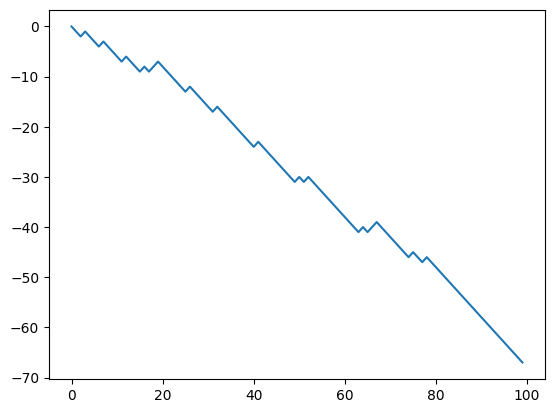

In [4]:
theta = 0.2
n_timesteps = 100
x = random_walk(theta, n_timesteps)
plt.plot(x)

So the model seems to be working fine. Now what we are interested is in computing the jacobian 

$$
(J)_i = \frac{\partial {x_i}}{\partial \theta}
$$

which we will later use for calibration. If we try to use torch's autograd to compute the jacobian:

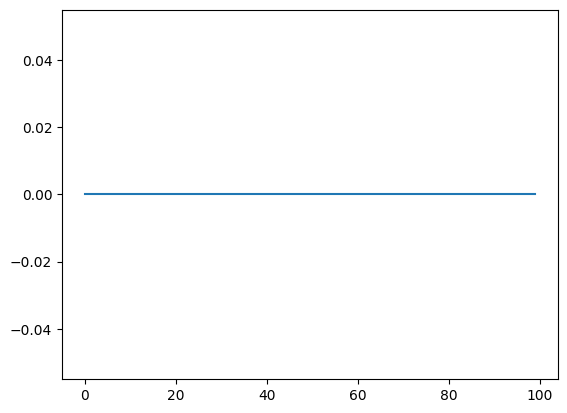

In [5]:
dx_dtheta = torch.autograd.functional.jacobian(
    lambda x: random_walk(theta=x, n_timesteps=n_timesteps), torch.tensor(theta)
)
plt.plot(dx_dtheta)

We obtain a gradient of 0. Why is that? There are two main reasons:

1. As we noted in the previous tutorials, the Bernoulli distribution is not automatically differentiable, and we need to use a continuous relaxation such as Gumbel-Softmax.
2. AD frameworks such as PyTorch require a static computation graph to perform AD. That means that, even though they support control flow statement such as if or else, they do not support control flow statements that depend on the parameters that we want to differentiate to. This can be circumvented by using masks. That is, a statement

```python
xi = torch.distributions.Bernoulli(theta)
if x:
    return a
else:
    return b
```

can be written as

```python
xi = torch.distributions.Bernoulli(theta)
y = xi * a + (1-xi) * b
```

with this in mind, we can rewrite our example as:


In [6]:
def random_walk(theta, n_timesteps, tau=0.1):
    x = torch.tensor([0.0])
    for i in range(n_timesteps - 1):
        logits = torch.hstack((theta, 1 - theta)).log()
        xi = torch.nn.functional.gumbel_softmax(logits, tau=tau, hard=True)[0]
        next_x = x[-1] + 2 * xi - 1
        x = torch.hstack((x, next_x))
    return x

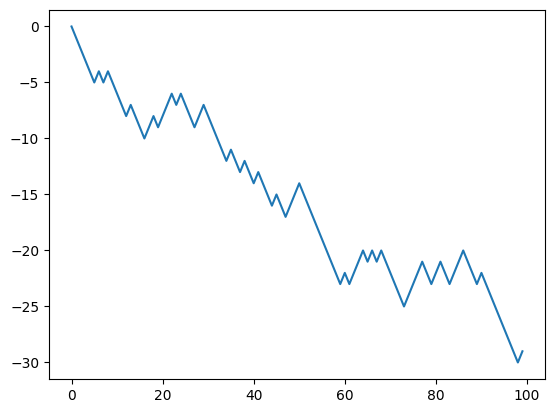

In [9]:
theta = torch.tensor(0.4)
n_timesteps = 100
x = random_walk(theta, n_timesteps)
plt.plot(x)

Now, remember, because of the `hard=True` the forward simulation is identical to the previous case. That is, the continuous relaxation that we model with Gumbel-Softmax only affects the backward gradient propagation. Let us now recompute the jacobian:

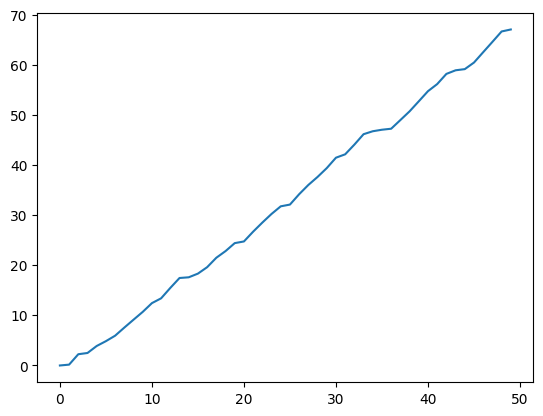

In [27]:
dx_dtheta = torch.autograd.functional.jacobian(
    lambda x: random_walk(theta=x, n_timesteps=n_timesteps, tau=1.0), theta
)
plt.plot(dx_dtheta)

and now we have a gradient! The temperature parameter of the GS distribution entails a bias-variance tradeoff as explained in the previous notebook. Let's analyze the effect here.

In [37]:
taus = [0.1, 0.5, 1.0]
n_gradient_samples = 50
n_timesteps = 50
gradients_per_tau = {tau: [] for tau in taus}
for tau in taus:
    for i in range(n_gradient_samples):
        dx_dtheta = torch.autograd.functional.jacobian(
            lambda x: random_walk(theta=x, n_timesteps=n_timesteps, tau=tau),
            theta,
            vectorize=True,
        )
        gradients_per_tau[tau].append(dx_dtheta)

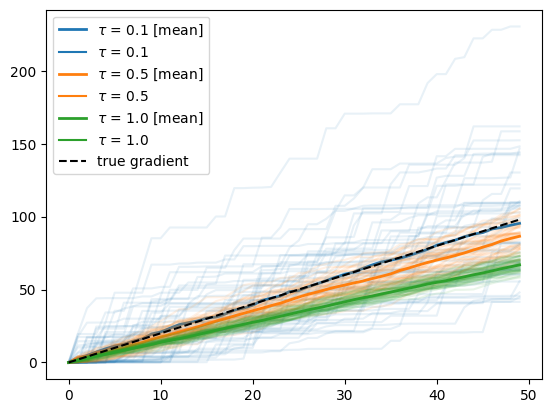

In [42]:
fig, ax = plt.subplots()
for i, tau in enumerate(gradients_per_tau):
    for grad in gradients_per_tau[tau]:
        ax.plot(grad, color=f"C{i}", alpha=0.1)
    ax.plot(
        sum(gradients_per_tau[tau]) / n_gradient_samples,
        color=f"C{i}",
        #linestyle="",
        label=rf"$\tau$ = {tau} [mean]",
        lw=2
    )
    ax.plot([], [], color=f"C{i}", label=rf"$\tau$ = {tau}")
ax.plot(
    range(n_timesteps),
    2 * np.array(range(n_timesteps)),
    color="black",
    linestyle="--",
    label="true gradient",
)
ax.legend()

First let's address how we obtained the true gradient value by the black dashed line $y=x$. Since the random walk is a linear model, we can write

$$
\begin{align}
\frac{\partial}{\partial \theta} \mathbb E[x_N]  & = \frac{\partial}{\partial \theta} \mathbb E\left[ \sum_{j=1}^{N} 2 \mathrm{Bernoulli(\theta)} - 1 \right]\\
                                                 & = \frac{\partial}{\partial \theta} (2  N  \theta - N) \\
                                                 & = 2 N
\end{align}
$$

Second, we observe that for decreasing values of $\tau$, the mean of the gradient estimate gets closer to the true values, but the variance increases significantly. In this particular case, we may do better with $\tau=0.5$ than $\tau=0.1$ since the small bias is an acceptable trade for a big reduction in variance.

# 2. SIR model

Let us know code a differentiable Susceptible-Infected-Recovered epidemiological model. The ABM is a discretization of the system of equations

$$
\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= - \beta SI \\
\frac{\mathrm{d} I}{\mathrm{d} t} &=  \beta SI - \gamma I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma I \\
\end{align}

$$

where $\beta$ is the effective contact rate (higher values correspond to faster disease spread), and $\gamma$ is the recovery rate (e.g., a $\gamma =0.05$ corresponds to a mean recovery time of 20 days), and S, I, R are the fraction of susceptible, infected, and recovered individuals respectively.

The corresponding agent-based model can be obtained by considering a collection of $N$ agents. At each time-step, the probability of agent $i$ getting infected is given by

$$
p_i = 1 - \exp{\left(-\beta I \Delta t\right)},
$$

where $I$ is the fraction of individuals infected at this time, and $\Delta t$ is the duration of the time-step. Likewise, an infected individual can recover with probability

$$
q_i = 1 - \exp{\left(-\gamma \Delta t\right)}.
$$

In [43]:
def sample_bernoulli(p, tau):
    logits = torch.vstack([p, 1 - p]).t().log()
    return torch.nn.functional.gumbel_softmax(logits=logits, tau=tau, hard=True)[:, 0]


def sir(
    beta, gamma, initial_fraction_infected, n_agents, n_timesteps, delta_t, tau=0.5
):
    # here S, I, R denote arrays of size (n_agents, ) with 1 or 0 depending on their state.
    I = sample_bernoulli(initial_fraction_infected * torch.ones(n_agents), tau)
    S = 1.0 - I
    R = torch.zeros(n_agents)
    infections_per_timestep = torch.tensor([])
    recoveries_per_timestep = torch.tensor([])
    for _ in range(n_timesteps):
        # sample probs
        probs_infected = S * (1.0 - torch.exp(-beta * sum(I) / n_agents * delta_t))
        probs_infected = torch.clip(probs_infected, 1e-8, 1.0)
        is_infected = sample_bernoulli(probs_infected, tau)
        probs_recovery = I * (1.0 - torch.exp(-gamma * delta_t))
        probs_recovery = torch.clip(probs_recovery, 1e-8, 1.0)
        is_recovered = sample_bernoulli(probs_recovery, tau)
        # update
        S = S - is_infected
        I = I + is_infected - is_recovered
        R = R + is_recovered
        # save
        infections_per_timestep = torch.hstack(
            (infections_per_timestep, is_infected.sum() / n_agents)
        )
        recoveries_per_timestep = torch.hstack(
            (recoveries_per_timestep, is_recovered.sum() / n_agents)
        )
    return infections_per_timestep, recoveries_per_timestep

In [53]:
beta = torch.tensor(0.2)
gamma = torch.tensor(0.05)
initial_fraction_infected = 0.01
n_agents = 10000
n_timesteps = 60
delta_t = 1

inf_t, rec_t = sir(beta, gamma, initial_fraction_infected, n_agents, n_timesteps, delta_t)

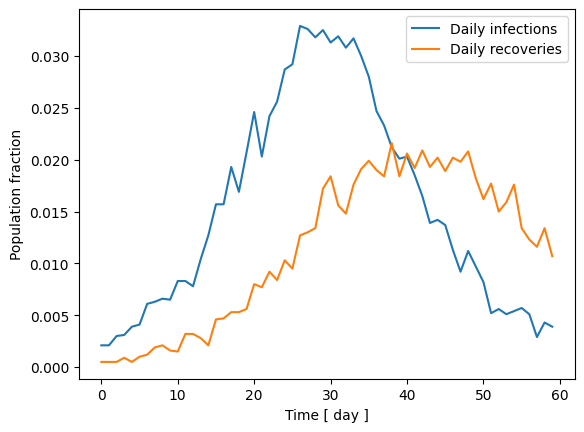

In [55]:
fig, ax = plt.subplots()
ax.plot(inf_t, label = "Daily infections")
ax.plot(rec_t, label = "Daily recoveries")
ax.set_xlabel("Time [ day ]")
ax.set_ylabel("Population fraction")
ax.legend()

## 2.2 Gradients of the SIR model

Similarly as the random walk model, we can now easily obtain the gradients of the infections and recoveries time-series.

In [57]:
# fixed parameters
initial_fraction_infected = 0.01
n_agents = 1_000
delta_t = 1
n_timesteps = 60
def faux(x):
    beta, gamma = x
    return sir(beta, gamma, initial_fraction_infected, n_agents, n_timesteps, delta_t)

beta = 0.2
gamma = 0.05
jacobian = torch.autograd.functional.jacobian(faux, torch.tensor([beta, gamma]), vectorize=True)

Text(0, 0.5, 'Gradient')

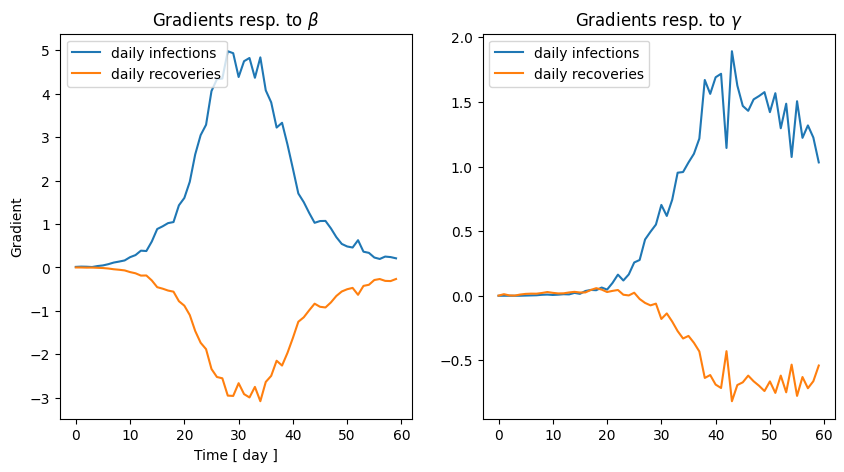

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(jacobian[0][:,0], label = "daily infections")
ax[0].plot(jacobian[0][:,1], label = "daily recoveries")
ax[0].set_title(r"Gradients resp. to $\beta$")
ax[0].legend()
ax[1].plot(jacobian[1][:,0], label = "daily infections")
ax[1].plot(jacobian[1][:,1], label = "daily recoveries")
ax[1].set_title(r"Gradients resp. to $\gamma $")
ax[1].legend()
ax[0].set_xlabel("Time [ day ]")
ax[0].set_ylabel("Gradient")

## 2.3 Fitting by gradient descent

It's about time to do what we set up to do with this tutorial: using the gradients to calibrate our model.

Let's assume we have an observed (multivariate) time-series $\mathbf y$. We want to compute the "optimal" values of $\beta$ and $\gamma$ that generate $\mathbf x$ that is as close as possible as $\mathbf y$. More specifically, we want to compute

$$
(\beta^*, \gamma^*) = \argmin_{(\beta, \gamma)} \ell \, \left(\mathbf x(\beta, \gamma), \mathbf y\right)
$$

where $\ell$ is an appropritate distance function. In this case, we will just consider the standard L2 loss.

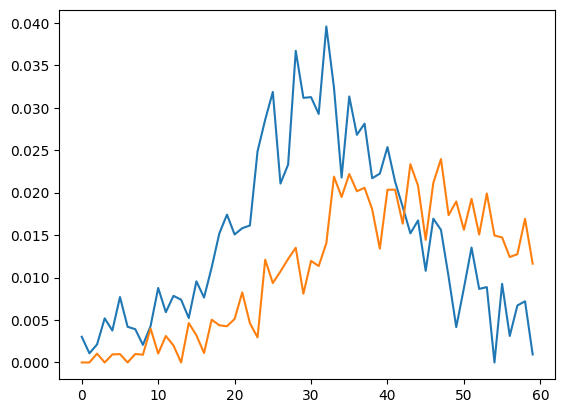

In [59]:
# let's generate some fake observation data first
true_beta = torch.tensor(0.2)
true_gamma = torch.tensor(0.05)
true_inf, true_rec = sir(
    true_beta, true_gamma, initial_fraction_infected, n_agents, n_timesteps, delta_t
)
# let's add some observation noise
sigma_obs = 0.05
true_inf = true_inf + torch.randn(n_timesteps) * sigma_obs * true_inf
true_rec = true_rec + torch.randn(n_timesteps) * sigma_obs * true_rec

f, ax = plt.subplots(1, 1)
ax.plot(true_inf, label = "daily infections")
ax.plot(true_rec, label = "daily recoveries")


In [60]:
# now let's find the best fit through gradient descent and try to recover the true parameters
# one thing to consider is that gradient descent is not a constrained optimization method
# so to avoid beta and gamma to go negative we will use a log transformation
log_beta = torch.tensor(0.0, requires_grad=True)
log_gamma = torch.tensor(0.0, requires_grad=True)
def loss(log_beta, log_gamma, obs_inf, obs_rec):
    beta = 10 ** log_beta
    gamma = 10 ** log_gamma
    inf, rec = sir(beta, gamma, initial_fraction_infected, n_agents, n_timesteps, delta_t)
    return torch.sum((inf - obs_inf) ** 2 + (rec - obs_rec) ** 2)

from tqdm import tqdm

n_epochs = 200
loss_hist = []
beta_hist = []
gamma_hist = []
optimizer  = torch.optim.Adam([log_beta, log_gamma], lr=0.05)
for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    l = loss(log_beta, log_gamma, true_inf, true_rec)
    l.backward()
    # clip norm this is important to avoid exploding gradients
    torch.nn.utils.clip_grad_norm_([log_beta, log_gamma], 1)
    optimizer.step()
    loss_hist.append(l.item())
    beta_hist.append(10 ** log_beta.item())
    gamma_hist.append(10 ** log_gamma.item())

100%|██████████| 200/200 [01:27<00:00,  2.28it/s]


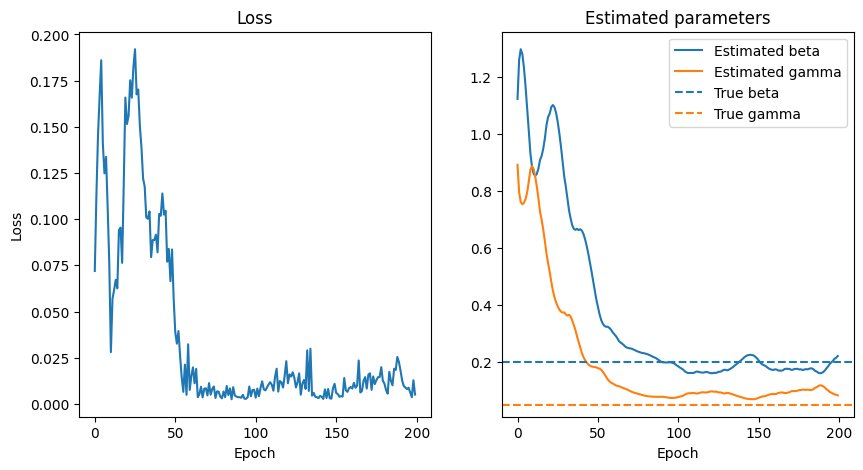

In [63]:
# let's see the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(loss_hist)
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_title("Estimated parameters")
ax[1].plot(beta_hist, label = "Estimated beta", color = "C0")
ax[1].plot(gamma_hist, label = "Estimated gamma", color = "C1")
ax[1].axhline(true_beta, color="C0", linestyle="--", label="True beta")
ax[1].axhline(true_gamma, color="C1", linestyle="--", label="True gamma")
ax[1].set_xlabel("Epoch")
ax[1].legend()
